In [ ]:
pip install tqdm boto3 requests regex sentencepiece sacremoses

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install keras_preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import transformers
import re
import torch
import tensorflow

In [ ]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [ ]:
train_data

,Unnamed: 0,Sentences,Sentiment
0,0,Working with one of the best Shakespeare sourc...,0
1,1,"Well...tremors I, the original started off in ...",0
2,2,Ouch! This one was a bit painful to sit throug...,0
3,3,"I've seen some crappy movies in my life, but t...",0
4,4,"""Carriers"" follows the exploits of two guys an...",0
...,...,...,...
1995,1995,"Without ""mental anachronism"", this film which ...",1
1996,1996,This movie is just great. It's entertaining fr...,1
1997,1997,I've seen the original English version on vide...,1
1998,1998,"Hello, I was alanrickmaniac. I'm a Still Crazy...",1


In [ ]:
test_data

,Unnamed: 0,Sentences,Sentiment
0,0,Alan Rickman & Emma Thompson give good perform...,0
1,1,I have seen this movie and I did not care for ...,0
2,2,"In Los Angeles, the alcoholic and lazy Hank Ch...",0
3,3,"This film is bundled along with ""Gli fumavano ...",0
4,4,I only comment on really very good films and o...,0
...,...,...,...
495,495,So after years and years I finally track this ...,1
496,496,I'm astonished how a filmmaker notorious for h...,1
497,497,We all enjoyed the movie. It is a very charmin...,1
498,498,"Fascinating and amusingly bad, Lights of New Y...",1


In [ ]:
train_texts, train_labels = train_data["Sentences"], train_data["Sentiment"]
test_texts, test_labels = test_data["Sentences"], test_data["Sentiment"]
len(train_texts), len(train_labels), len(test_texts), len(test_labels)

(2000, 2000, 500, 500)

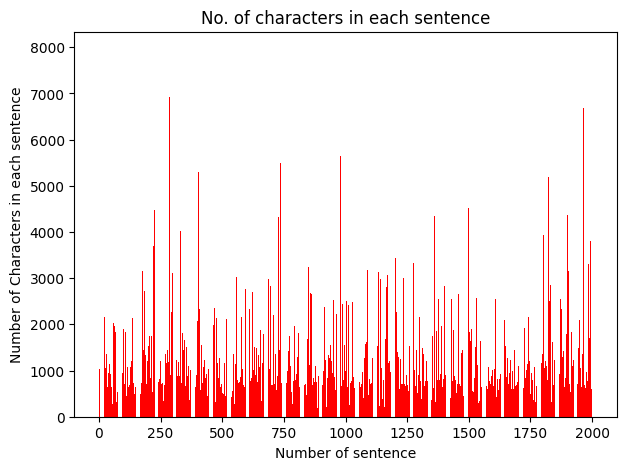

In [ ]:
sentences = [len(sent) for sent in train_texts]

plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
plt.bar(range(1,2001), sentences, color = ['red'])
plt.gca().set(title='No. of characters in each sentence', xlabel='Number of sentence', ylabel='Number of Characters in each sentence');

In [ ]:
from transformers import BertTokenizer
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')    # Download vocabulary from S3 and cache


Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


In [ ]:
tokenizer.tokenize('Hi my name is Atul')

['hi', 'my', 'name', 'is', 'at', '##ul']

In [ ]:
train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], train_texts))
test_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], test_texts))

len(train_tokens), len(test_tokens)

Token indices sequence length is longer than the specified maximum sequence length for this model (1013 > 512). Running this sequence through the model will result in indexing errors


(2000, 500)

In [ ]:
from keras_preprocessing.sequence import pad_sequences
train_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, train_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")
test_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, test_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")

train_tokens_ids.shape, test_tokens_ids.shape


((2000, 512), (500, 512))

In [ ]:
print(train_tokens_ids)

[[  101  2551  2007 ...     0     0     0]
 [  101  2092  1012 ...     0     0     0]
 [  101 15068  2818 ...     0     0     0]
 ...
 [  101  1045  1005 ...     0     0     0]
 [  101  7592  1010 ...     0     0     0]
 [  101  1999  2070 ... 10021  2066   102]]


In [ ]:
train_y = np.array(train_labels) == 1
test_y = np.array(test_labels) == 1
train_y.shape, test_y.shape, np.mean(train_y), np.mean(test_y)

((2000,), (500,), 0.5, 0.5)

In [ ]:
train_masks = [[float(i > 0) for i in ii] for ii in train_tokens_ids]
test_masks = [[float(i > 0) for i in ii] for ii in test_tokens_ids]

In [ ]:
print(train_masks)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
from torch import nn
from transformers import BertModel

class BertBinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertBinaryClassifier, self).__init__()

        self.bert = torch.hub.load('huggingface/pytorch-transformers', 'model', 'bert-base-uncased', output_attentions=True)  # Update configuration during loading

        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, tokens, masks=None):
        outputs = self.bert(tokens, attention_mask=masks, return_dict=True)
        pooled_output = outputs.pooler_output
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        proba = self.sigmoid(linear_output)
        return proba

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'0.0M'

In [ ]:
bert_clf = BertBinaryClassifier()
bert_clf = bert_clf.cuda()     # running BERT on CUDA_GPU

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'439.07328M'

In [ ]:
x = torch.tensor(train_tokens_ids[:3]).to(device)
y = bert_clf.bert(x)
pooled = y.pooler_output
x.shape, pooled.shape

(torch.Size([3, 512]), torch.Size([3, 768]))

In [ ]:
y = bert_clf(x)
y.cpu().detach().numpy()        # kinda Garbage Collector to free up used and cache space

array([[0.35172006],
       [0.32806876],
       [0.3832009 ]], dtype=float32)

In [ ]:
# Cross- checking CUDA GPU Memory to ensure GPU memory is not overflowing.
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'3185.033728M'

In [ ]:
y, x, pooled = None, None, None
torch.cuda.empty_cache()     # Clearing Cache space for fresh Model run
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'3185.033728M'

###Fine Tune Bert

In [ ]:
# Setting hyper-parameters

BATCH_SIZE = 4
EPOCHS = 10

In [ ]:
train_tokens_tensor = torch.tensor(train_tokens_ids)
train_y_tensor = torch.tensor(train_y.reshape(-1, 1)).float()

test_tokens_tensor = torch.tensor(test_tokens_ids)
test_y_tensor = torch.tensor(test_y.reshape(-1, 1)).float()

train_masks_tensor = torch.tensor(train_masks)
test_masks_tensor = torch.tensor(test_masks)

str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'447.59296M'

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

In [ ]:
param_optimizer = list(bert_clf.sigmoid.named_parameters()) 
optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

In [ ]:
from torch.optim import Adam
optimizer = Adam(bert_clf.parameters(), lr=3e-6)

In [ ]:
torch.cuda.empty_cache()   # Clearing Cache space for a fresh Model run

In [ ]:
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output
for epoch_num in range(EPOCHS):
    bert_clf.train()
    train_loss = 0
    for step_num, batch_data in enumerate(train_dataloader):
        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)
        print(str(torch.cuda.memory_allocated(device)/1000000 ) + 'M')
        logits = bert_clf(token_ids, masks)
        
        loss_func = nn.BCELoss()

        batch_loss = loss_func(logits, labels)
        train_loss += batch_loss.item()
        
        
        bert_clf.zero_grad()
        batch_loss.backward()
        

        clip_grad_norm_(parameters=bert_clf.parameters(), max_norm=1.0)
        optimizer.step()
        
        clear_output(wait=True)
        print('Epoch: ', epoch_num + 1)
        print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(train_data) / BATCH_SIZE, train_loss / (step_num + 1)))

Epoch:  10
499/500.0 loss: 0.019119310782669346 


In [ ]:
bert_clf.eval()
bert_predicted = []
all_logits = []
with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        logits = bert_clf(token_ids, masks)
        loss_func = nn.BCELoss()
        loss = loss_func(logits, labels)
        numpy_logits = logits.cpu().detach().numpy()
        
        bert_predicted += list(numpy_logits[:, 0] > 0.5)
        all_logits += list(numpy_logits[:, 0])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_y, bert_predicted))

              precision    recall  f1-score   support

       False       0.91      0.91      0.91       250
        True       0.91      0.91      0.91       250

    accuracy                           0.91       500
   macro avg       0.91      0.91      0.91       500
weighted avg       0.91      0.91      0.91       500



In [ ]:
wrong = {"z_o" : [], "o_z": []}
true = []
i = 0
for a,b in zip(bert_predicted,test_y):
  if a == 0 and b == 1: #false positive
    wrong["z_o"].append(i)
  elif a == 1 and b == 0: #false negative
    wrong["o_z"].append(i)
  else:
    true.append(i)
  i += 1
print(len(wrong["z_o"]), len(wrong["o_z"]))
print(len(true))

22 22
456


In [ ]:
import random as rand
false_positive_index = rand.choice(wrong["z_o"])
false_negative_index= rand.choice(wrong["o_z"])

print(false_positive_index)
print(false_negative_index)

379
0


In [ ]:
false_positive_sentence = test_data.iloc[false_positive_index]["Sentences"]
false_negative_sentence = test_data.iloc[false_negative_index]["Sentences"]
print(false_positive_sentence)
print(false_negative_sentence)

I cannot understand the need to jump backwards and forwards to scene set, and pad out the plot. Showing that someone has a skill right before they use it, I believe, is offending our intelligence. It's starting to feel a little contrived, and as though they are making up for being so vague for the first three series. A little disappointing this episode.Furthermore, using past quirks, like Locke's ability to know when a storm is ending, is frankly insulting... are we supposed to ooh and arr, or laugh at the softer side of Locke?This episode was all over the place.
Alan Rickman & Emma Thompson give good performances with southern/New Orleans accents in this detective flick. It's worth seeing for their scenes- and Rickman's scene with Hal Holbrook. These three actors mannage to entertain us no matter what the movie, it seems. The plot for the movie shows potential, but one gets the impression in watching the film that it was not pulled off as well as it could have been. The fact that it i

In [ ]:
from transformers import BertTokenizer

tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')    # Download vocabulary from S3 and cache

encoded_false_pos_sentence = tokenizer.encode_plus(
                        false_positive_sentence,                       # Sentence to encode
                        add_special_tokens = True,       # Add [CLS] and [SEP] tokens
                        padding = 'max_length',          # Pad sentence to max_length
                        max_length = 512,                 # Max sentence length in tokens
                        truncation = True,               # Truncate longer sentences
                        return_attention_mask = True,    # Return attention mask
                        return_tensors = 'pt'            # Return PyTorch tensors
                  )

print(len(encoded_false_pos_sentence['input_ids'].detach().numpy()[0]))
# print(encoded_false_neg_sentence['attention_mask'])

512


Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


In [ ]:
model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'bert-base-uncased', output_attentions=True)  # Update configuration during loading
#predict
pred = model(encoded_false_pos_sentence['input_ids'], attention_mask = encoded_false_pos_sentence['attention_mask'], output_attentions = "True")

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
attention_scores = pred[-1][0]
attention_scores.shape

torch.Size([1, 12, 512, 512])